In [1]:
import sys
import networkx as nx
from terminaltables import AsciiTable
%matplotlib inline

# Dijkstra's algorithm

Dijkstra's algorithm is an algorithm for finding the shortest paths between nodes in a graph, which may represent computer networks. For a given source node in the graph, the algorithm finds the shortest path between that node and every other. The shortest path algorithm is widely used in network routing protocols, most notably IS-IS (Intermediate System to Intermediate System) and Open Shortest Path First (OSPF). 

## Notations

- $c(x,y)$: link cost from node $x$ to node $y$
- $D(d)$: current value of cost of path from source to destination $d$
- $p(v)$: predecessor node along path from source to $v$
- $N'$: set of nodes whose least cost path definitively known 

### Initialization

Set the source node to $N'$, then set the path cost from source to neighboring nodes (nodes with physical connection) to the link cost. For those nodes that are not neighbors, set the path cost to a large number. 

1. N’ = {u}
2.    for all nodes v
3.      if v is a neighbor of u
4.         then D(v) = c(u,v)
5.      else D(v) = inf 

### Loop

Then update the current path cost based on the following rule: 
**new cost to destination $v$ is either old cost to $v$ or known least path cost to a relay node $w$ plus the link cost from $w$ to the destination $v$.**

6.    find w not in N’ such that D(w) is a minimum
7.   add w to N’
8.   update D(v) for each neighbor v of w and not in N’:
9.         D(v) = min( D(v), D(w) + c(w,v) )


**Exercise:** Implement `link_state()` that initializes Dijkstra algorithm. 

In [2]:
def link_state(source_node, network_topology, show_table=False):
    
    # get network topology nodes
    nodes = network_topology['nodes']
    
    # get network topology links
    links = network_topology['links'].keys()
    
    # get the link costs in network topology
    link_cost = network_topology['links']
    
    
    
    # define the Dijkstra table
    Dijkstra_table = [
    ['Step', 'N'],
    ]
    for node in nodes:
        Dijkstra_table[0].append('D(' + str(node) + ')')
        Dijkstra_table[0].append('p(' + str(node) + ')')
    
    
    
    # define N’ as a set() and add source node to it (two lines)
    N = set()
    N.add(source_node)
    
    # define path cost D as dictionary
    D = {}
    
    # define predecessor as dictionary
    p = {}
    
    # Initialization
    
    # initalize steps to zero
    step = 0
    
    # Dijkstra_table_row
    Dijkstra_table_row = [str(step), str(N)]
    
    # for all nodes in network topology 
    for node in nodes:
        if node is source_node:
            Dijkstra_table_row.append('')
            Dijkstra_table_row.append('')
            continue
        
        # if v is a neighbor of u
        if (source_node, node) in links or (node, source_node) in links:
            D[node] = link_cost[(source_node, node)] if (source_node, node) in link_cost else link_cost[(node, source_node)]
            p[node] = source_node
        
        else:
            D[node] = sys.maxsize
            p[node] = 'N/A'
        
        D_label = 'inf' if D[node] == sys.maxsize else str(D[node])
        Dijkstra_table_row.append(D_label)
        Dijkstra_table_row.append(str(p[node]))
    
    Dijkstra_table.append(Dijkstra_table_row)
    
    
    # loop
    
    # check whether all nodes in N
    condition = (nodes == N)
    
    
    # print(N,nodes)
    while not condition:
        
        # increment step
        step += 1
        
        # find a relay node not in N’ such that D(w) is a minimum
        relay_candidates = nodes - N
        relay_D = {}
        for r in relay_candidates:
            relay_D[r] = D[r]

        # find relay node with minimum D() value
        relay_node = sorted(relay_D, key=relay_D.get, reverse=False)[0]
        # print(relay_D,relay_node)
        # add relay_node to N
        N.add(relay_node)
        
        # update Dijkstra_table_row
        Dijkstra_table_row = [str(step), str(N)]
        
        for dest_node in nodes:
             
            # dest_node if already in N, skip it
            if dest_node in N:
                Dijkstra_table_row.append('')
                Dijkstra_table_row.append('')
                continue
            

            
            # make sure the link exist in the network topology
            relay_link = None # <== dont modify this "None" is the default value! 
            if (relay_node, dest_node) in link_cost:
                relay_link = (relay_node, dest_node)
            elif (dest_node , relay_node) in link_cost:
                relay_link = (dest_node , relay_node)

            if relay_link:
                if D[dest_node] > (D[relay_node] + link_cost[relay_link]) : # if( D(v) > D(w) + c(w,v) )
                    #update D(v)
                    D[dest_node] = D[relay_node] + link_cost[relay_link]
                    # update p for this destination node
                    p[dest_node] = relay_node
                
            D_label = 'inf' if D[dest_node] == sys.maxsize else str(D[dest_node])
            Dijkstra_table_row.append(D_label)
            Dijkstra_table_row.append(str(p[dest_node]))
    
        Dijkstra_table.append(Dijkstra_table_row)    
            
        
        
        # update the while condition
        condition = (nodes == N)
    
    
    # print(Dijkstra_table)
    table = AsciiTable(Dijkstra_table)
    if show_table:
        print(table.table)
    
    return p
    

## Network abstraction with Graphs 
We use graphs $G=(N,E)$ to represent network abstraction where

- $N$: represents nodes (routers) in the network
- $E$: represents links in the network

### Networkx

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. We use this package to draw the graph abstraction of the network topology. Using networkx, we can define costs for each link as *weight* of that link.

**Exercise:** Implement `draw_network()`. Use networkx to draw a given network topology that includes nodes, links and their costs. Assume that `network_topology` is a Python dictionary with the following keys and values:

- `network_topology["nodes"]`: is a set of numbers representing the node ids (router ids, e.g., 1,2,3) in the network.
- `network_topology["links"]`: is a dictionary with keys as link tuples (e.g., (1,2)) and values that represent the corresponding link cost.


In [3]:
def draw_network(network_topology):
    # get network topology nodes
    nodes = network_topology['nodes']
    
    # get network topology links
    links = network_topology['links'].keys()
    
    # get the link costs in network topology
    link_cost = network_topology['links']
    
    # define an empty graph in networkx
    G = nx.Graph()
    
    # add nodes to graph G
    for node in nodes:
        G.add_node(node)
    
    # add edges to graph G using links
    for link in links:
        G.add_edge(*link)
    
    # specify the layout of the graph
    # we use random layout
    pos = nx.random_layout(G)
    
    # draw the network nodes and edges
    nx.draw_networkx(G, pos)
    
    # draw the link costs as labels for each edge
    # make costs as labels for each link
    link_labels = {}
    for link, cost in link_cost.items():
        link_labels[link]= str(cost)
    
    # draw the link costs
    nx.draw_networkx_edge_labels(G,pos,edge_labels=link_labels)
        
    
    
    

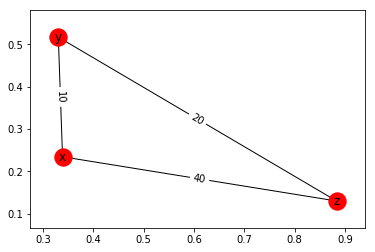

In [4]:
network_topology = {}
network_topology['nodes'] = set(['x','y','z'])
network_topology['links'] = {('x','y'): 10, ('y','z'): 20,  ('x','z'): 40}
draw_network(network_topology)

**Expected output:**
<img src='images/three_node_top.png' >

In [5]:
source_node = 'y'
link_state(source_node, network_topology,True)

+------+-----------------+------+------+------+------+------+------+
| Step | N               | D(z) | p(z) | D(x) | p(x) | D(y) | p(y) |
+------+-----------------+------+------+------+------+------+------+
| 0    | {'y'}           | 20   | y    | 10   | y    |      |      |
| 1    | {'x', 'y'}      | 20   | y    |      |      |      |      |
| 2    | {'z', 'x', 'y'} |      |      |      |      |      |      |
+------+-----------------+------+------+------+------+------+------+


{'z': 'y', 'x': 'y'}

**Expected output:**
```

+------+-----------------+------+------+------+------+------+------+
| Step | N               | D(z) | p(z) | D(y) | p(y) | D(x) | p(x) |
+------+-----------------+------+------+------+------+------+------+
| 0    | {'y'}           | 20   | y    | 10   | y    |      |      |
| 1    | {'y', 'x'}      | 20   | y    |      |      |      |      |
| 2    | {'z', 'y', 'x'} |      |      |      |      |      |      |
+------+-----------------+------+------+------+------+------+------+

{'z': 'y', 'x': 'y'}
```

## Shortest Path Tree
The link_state algorithm determines the shortest paths from the source to other nodes in the network. The output of this algorithm also includes predecessor node's path for each destination. Using this information, we can draw the shortest path tree. This will help us to populate the forwarding table for the source.

**Exercise:** Implement `get_SPT()` to generate the shortest path tree for a given network topology.

In [6]:
def get_SPT(source_node, network_topology, draw_tree=False):
    
       
    # create empty dict for SPT
    SPT_tree = {'nodes': set(),
                'links': {}}
 
    # run link_state algorithm to get the predecessor list
    predecessors = link_state(source_node, network_topology)
    
    
    # go through the predecessors list and make the tree topology
    for dest_node, pred_node in predecessors.items():
        # add the pred_node to SPT nodes
        SPT_tree['nodes'].add(pred_node)
        
        # add the dest_node to SPT nodes
        SPT_tree['nodes'].add(dest_node)
        
        # add the (pred_node, dest_node) and its cost to SPT links
        tmp_link = (pred_node, dest_node) if (pred_node, dest_node) in network_topology['links'] else (dest_node,pred_node)
        SPT_tree['links'][tmp_link] = network_topology['links'][tmp_link]
    
    
    if draw_tree:
        draw_network(SPT_tree)
    
    return SPT_tree
        
    
    
    
    

{'nodes': {'x', 'y', 'z'}, 'links': {('y', 'z'): 20, ('x', 'y'): 10}}

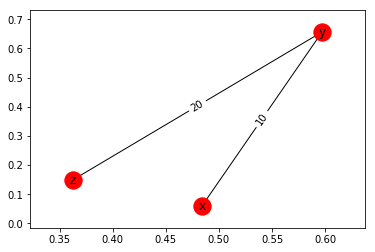

In [7]:
get_SPT(source_node, network_topology, draw_tree=True)

**Expected output:**
```
{'nodes': {'x', 'y', 'z'}, 'links': {('x', 'z'): 40, ('x', 'y'): 10}}
```
<img src='images/three_node_SPT.png' >

**Execrise:** Define the network topology of the text book at page 429 for P3. Run the `link_state()` and `get_SPT()` for each nodes listed in problem P4. Compare the generated table and shortest path three with your solutions you did on the paper.

+------+-------------------------------------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
| Step | N                                   | D(t) | p(t) | D(w) | p(w) | D(z) | p(z) | D(u) | p(u) | D(v) | p(v) | D(x) | p(x) | D(y) | p(y) |
+------+-------------------------------------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
| 0    | {'z'}                               | inf  | N/A  | inf  | N/A  |      |      | inf  | N/A  | inf  | N/A  | 8    | z    | 12   | z    |
| 1    | {'z', 'x'}                          | inf  | N/A  | 14   | x    |      |      | inf  | N/A  | 11   | x    |      |      | 12   | z    |
| 2    | {'z', 'x', 'v'}                     | 15   | v    | 14   | x    |      |      | 14   | v    |      |      |      |      | 12   | z    |
| 3    | {'z', 'x', 'y', 'v'}                | 15   | v    | 14   | x    |      |      | 14   | v    |      |      |      |      |

{'nodes': {'t', 'u', 'v', 'w', 'x', 'y', 'z'},
 'links': {('v', 't'): 4,
  ('x', 'w'): 6,
  ('v', 'u'): 3,
  ('x', 'v'): 3,
  ('z', 'x'): 8,
  ('z', 'y'): 12}}

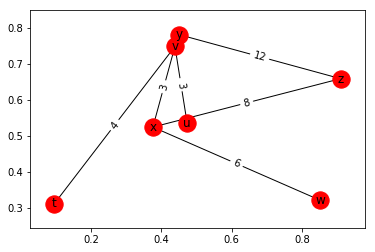

In [8]:
# network topology book page 429 P3

network_top = {'nodes': set(['z','x','y','w','v','u','t']),
              'links': {('z','x'): 8,
                        ('z','y'): 12,
                        ('x','y'): 6,
                        ('x','w'): 6,
                        ('x','v'): 3,
                        ('y','t'): 7,
                        ('y','v'): 8,
                        ('v','t'): 4,
                        ('v','w'): 4,
                        ('v','u'): 3,
                        ('t','u'): 2,
                        ('w','u'): 3
                       }
              }

## source node = 'z'
link_state(source_node='z', network_topology=network_top, show_table= True)
get_SPT(source_node='z', network_topology=network_top, draw_tree=True)